# Foundations Of AIML
## Session 11
### Experiment 2.1: Siamese networks

In [1]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
#from resnet import resnet18
from siamese_data_loader import *
from contrastive import *   ### implementation of contrastive loss
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [11]:
cf.data_dir = 'data/'

## IMFDB data is with 16 classes, Loading atleast 32 images per Batch of Train loader is exhauting memory
## So Test with IIC data which is only 5 classes and use 10 images per batch for training

#img_root = cf.data_dir+'IMFDB_final/'
#train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
#val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation

# img_root = "data/IMFDB_final/"
# train_list_file = "data/IMFDB_train.txt"        #### 5000 images for training
# val_list_file = "data/IMFDB_test.txt"           #### 1095 images for validation

img_root = "data/IIC/"
train_list_file = "data/IIC_train.txt"
val_list_file = "data/IIC_test.txt"
print(img_root,train_list_file)


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print (len(train_image_list), len(val_image_list))

### Notice a new data loader for siamese networks. This gives the image pairs (image_1, image_2) and a label as input to the siamese networks.
### see siamese_data_loader.py for details

trainloader = torch.utils.data.DataLoader(siamese_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128],classes = 'IIC'), 
                                           batch_size=16, num_workers=8, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(siamese_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],split = 'test',classes = 'IIC'), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=True)


#classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']
classes = ['baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali',  'priya_prakash']

data/IIC/ data/IIC_train.txt
1003 50


In [12]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the loss value as high value
best_loss = 99999999

num_classes = 5   ## For IIC data
#num_classes = 16  ## For IMFDB data
print(use_cuda)

True


In [13]:
feature_net = network_9layers()   ### creates an object of this network architecture
from collections import OrderedDict
new_state_dict = OrderedDict()
#state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
### load the learned lightCNN weights and map them to CPU since we dont have a GPU. The model weghts are trained on GPU and saved, so we need to remap to CPu 
state_dict = torch.load('data/light_cnn/LightCNN_9Layers_checkpoint.pth.tar',map_location=lambda storage, loc: storage)['state_dict']

for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)


layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))
#feature_net.fc2 = classifier
feature_net.fc2 = nn.Sequential(nn.Linear(256, 10))
if use_cuda:
    feature_net.cuda()
    classifier.cuda()
    


In [14]:
# for param in feature_net.fc2.parameters():
#     print(param.requires_grad)
#     print("---------")
# for param in feature_net.features.parameters():
#     print(param.requires_grad)

# print("---------")
# for param in feature_net.parameters():
#     print(param.requires_grad)

In [15]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()
margin = 1.8
siamese_loss = contrastive_loss(margin)   ### Notice a new loss. contrastive.py shows how to compute contrastive loss.

#### Lets train the siamese networks. The objective is images from same class (+ pair, label = 0) should have similar feature and images from different classes (- pair, label = 1) should have different features. Instead of having two physical networks sharing the weights, in implementation we have only one network and first pass image_1 (to get its feature) and then pass image_2 (to get its feature) through the same network. We then compute the contrastive loss on these feature pairs from input image pairs. This saves a lot of memory.

In [16]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    feature_net.train()
    train_loss = 0
    correct = 0
    total = 1
    for batch_idx, (inputs_1, inputs_2, targets) in enumerate(trainloader):
        
#         if targets.sum() >= 0.6*inputs_1.size()[0]:    ### ignore mini-batches with more than 90% negative samples.
#             continue
#         print targets.sum()/inputs_1.size()[0]
        if use_cuda:
            inputs_1, inputs_2, targets = inputs_1.cuda(), inputs_2.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs_1, inputs_2, targets = Variable(inputs_1), Variable(inputs_2), Variable(targets)
        features_1 = feature_net.get_features2(inputs_1)      ### get feature for image_1
        features_2 = feature_net.get_features2(inputs_2)      ### get feature for image_2
        
        loss = siamese_loss(features_1, features_2, targets.float())   ### compute the contrastive loss, computes the similarity between the features.
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        
        if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f '
                         % (train_loss/(batch_idx+1)))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [17]:
def test(epoch):
    global best_loss
    feature_net.eval()
    test_loss = 0
    correct = 0
    total = 1
    for batch_idx, (inputs_1, inputs_2, targets) in enumerate(testloader):
        if use_cuda:
            inputs_1, inputs_2, targets = inputs_1.cuda(), inputs_2.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs_1, inputs_2, targets = Variable(inputs_1), Variable(inputs_2), Variable(targets)
        features_1 = feature_net.get_features2(inputs_1)      
        features_2 = feature_net.get_features2(inputs_2)      
        
        loss = siamese_loss(features_1, features_2, targets.float())
        test_loss += loss.data[0]
        
        if batch_idx%10 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f '
                         % (test_loss/(batch_idx+1)))
        
    print ('val_loss: ',  test_loss/len(testloader))
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    losss = test_loss/len(testloader)
    if  losss < best_loss:   ### save model with the best loss so far
        print('Saving..') 
        state = {
            'net': feature_net
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/siamese_ckpt.t7')
        best_loss = losss
    
    return test_loss/len(testloader)

In [18]:
experiment = 'siamese_IIC/'
#train_loss_file = open(cf.data_dir+experiment+"/train_loss.txt", "w", 0)
#val_loss_file = open(cf.data_dir+experiment+"/val_loss.txt", "w", 0)
train_loss_file = open("data/siamese_IIC/train_loss.txt", "w+")
val_loss_file = open("data/siamese_IIC/val_loss.txt", "w+")

In [19]:
optimizer = optim.Adam(feature_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0


/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 [==================================>] | Loss: 206557.844                       63/63 


/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


 [============================>......] | Loss: 96307.500                        5/5 
val_loss:  tensor(96307.5000, device='cuda:0')
Saving..

Epoch: 1
 [==================================>] | Loss: 7700.881                         63/63 
 [============================>......] | Loss: 55309.926                        5/5 
val_loss:  tensor(55309.9258, device='cuda:0')
Saving..

Epoch: 2
 [==================================>] | Loss: 3559.983                         63/63 
 [============================>......] | Loss: 20369.492                        5/5 
val_loss:  tensor(20369.4922, device='cuda:0')
Saving..

Epoch: 3
 [==================================>] | Loss: 1729.181                         63/63 
 [============================>......] | Loss: 17609.188                        5/5 
val_loss:  tensor(17609.1875, device='cuda:0')
Saving..

Epoch: 4
 [==================================>] | Loss: 1164.771                         63/63 
 [============================>......] | Loss: 1

In [29]:
### After training we load the model that performed the best on validation data (avoid picking overfitted model)
### we will use the base pre-trained network for feature extraction only. This feature is used to train an MLP classifier.

feature_net = torch.load(cf.data_dir+'checkpoint/siamese_ckpt.t7')['net'].eval()

##### Lets see how well does the siamese detect an imposter. We check whether image_2 is same individual as image_1 or an imposter. We do this by computing dissimilarity score between features.

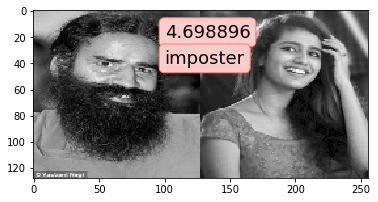

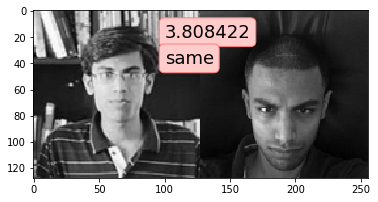

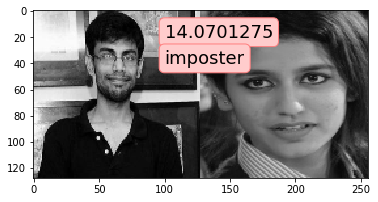

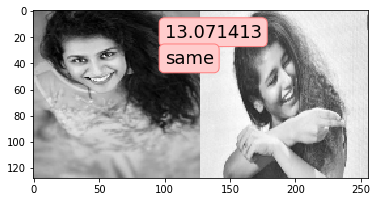

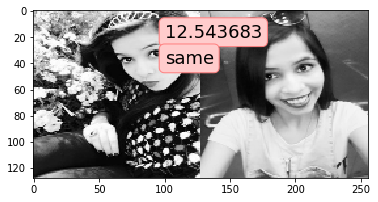

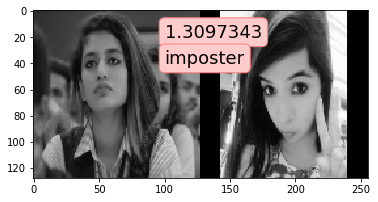

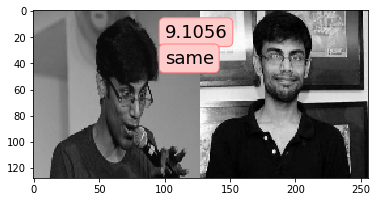

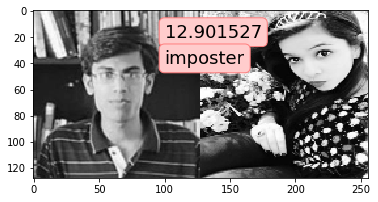

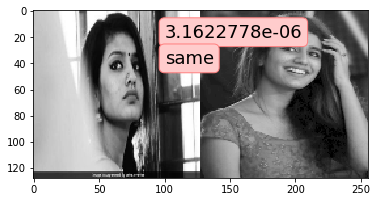

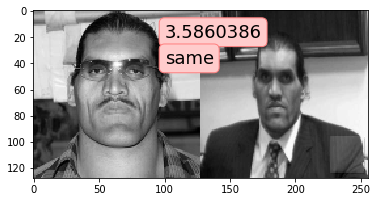

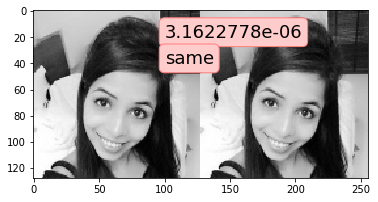

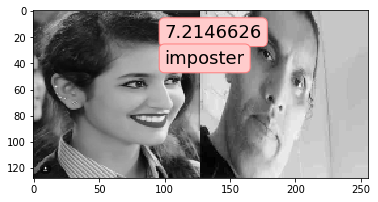

Matches, Total, Length of TestLoader, Accuracy:  15.0 50.0 50 30.0


In [30]:
testloader = torch.utils.data.DataLoader(siamese_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],split = 'test',classes = 'IIC'), 
                                           batch_size=1, num_workers=0, shuffle = False, pin_memory=True)
matches = 0.0
Total = 0.0
similarity_thres = 10.0
lab = ['same', 'imposter']
for batch_idx, (inputs_1, inputs_2, targets) in enumerate(testloader):
    #if batch_idx%10 == 0 or int(targets)==0:      ### show every tenth image or if its the same individual
        
        if use_cuda:
            inputs_1, inputs_2, targets = inputs_1.cuda(), inputs_2.cuda(), targets.cuda()
        
        Total = Total+1
        inputs_1, inputs_2, targets = Variable(inputs_1), Variable(inputs_2), Variable(targets)
        features_1 = feature_net.get_features2(inputs_1)      
        features_2 = feature_net.get_features2(inputs_2)
        #print(features_1)
        #dissimilarity1 = F.pairwise_distance(features_1, features_2).data
        #dissimilarity2 = F.pairwise_distance(features_1, features_2).data[0].cpu().numpy()
        #print(dissimilarity1, dissimilarity2)
        dissimilarity = F.pairwise_distance(features_1, features_2).data[0].cpu().numpy()
        #dissimilarity = F.pairwise_distance(features_1, features_2).data[0].cpu().numpy()[0]
        if dissimilarity < similarity_thres:
            label = 0
        else:
            label = 1
        if label == int(targets):
            matches = matches+1
            
        if batch_idx%10 == 0 or int(targets)==0:      ### show every tenth image or if its the same individual
            img = np.concatenate((inputs_1.data.cpu().numpy()[0][0], inputs_2.data.cpu().numpy()[0][0]), axis = 1)
            plt.imshow(img, cmap='gray')
            plt.text(100,20,str(dissimilarity), fontsize=18,bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       ))     ### similarity score
            plt.text(100,40,lab[int(targets.data[0])], fontsize=18,bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       ))   ### ground truth
            plt.show()

print("Matches, Total, Length of TestLoader, Accuracy: ", matches, Total, len(testloader), (matches/Total)*100.0)

### Now we use this network for feature extraction and train an MLP classifier. Feature_net is not updated/train/tweak after this. We only train the MLP classifier.

In [31]:
from data_loader import custom_data_loader

# train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
# val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation
train_list_file = cf.data_dir+'IIC_train.txt'   #### 5000 images for training
val_list_file = cf.data_dir+'IIC_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print (len(train_image_list), len(val_image_list))

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128],split='train',classes = 'IIC'), 
                                          batch_size=32, num_workers=16, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],split='test',classes = 'IIC'), 
                                         batch_size=10, num_workers=5, shuffle = False, pin_memory=True)



1003 50


In [32]:
def train_classifier(epoch):
    print('\nEpoch: %d' % epoch)
    classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        features = feature_net.get_features(inputs).detach()       
        
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))


In [33]:
def test_classifier(epoch):
    global best_acc
    classifier.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print ('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [34]:
best_acc = 0
experiment = 'siamese_features_IIC/'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w+")
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w+")

In [35]:
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train_classifier(epoch)
    test_loss = test_classifier(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0


/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 [=================================>.] | Loss: 1.562 | Acc: 27.000% (279/1003)  32/32 


/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 [============================>......] | Loss: 1.510 | Acc: 34.000% (17/50)     5/5 
val_loss:  tensor(1.5104, device='cuda:0') accuracy:  tensor(34)
Saving..

Epoch: 1
 [=================================>.] | Loss: 1.436 | Acc: 45.000% (454/1003)  32/32 
 [============================>......] | Loss: 1.471 | Acc: 36.000% (18/50)     5/5 
val_loss:  tensor(1.4707, device='cuda:0') accuracy:  tensor(36)
Saving..

Epoch: 2
 [=================================>.] | Loss: 1.336 | Acc: 52.000% (525/1003)  32/32 
 [============================>......] | Loss: 1.418 | Acc: 46.000% (23/50)     5/5 
val_loss:  tensor(1.4176, device='cuda:0') accuracy:  tensor(46)
Saving..

Epoch: 3
 [=================================>.] | Loss: 1.223 | Acc: 56.000% (570/1003)  32/32 
 [============================>......] | Loss: 1.353 | Acc: 42.000% (21/50)     5/5 
val_loss:  tensor(1.3526, device='cuda:0') accuracy:  tensor(42)

Epoch: 4
 [=================================>.] | Loss: 1.130 | Acc: 61.000% (616

In [37]:
def eval():
    feature_net.eval()
    classifier.eval()
    
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],split='test',classes = 'IIC'), 
                                           batch_size=1, num_workers=1, shuffle = False, pin_memory=True)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = 1e-12+np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [38]:
conf, acc, wrong_predictions = eval()
print (acc)

/local/mnt/workspace/vgopired/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


tensor(56)


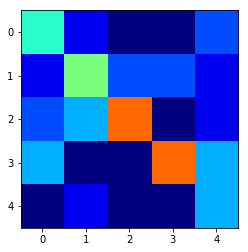

In [39]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

baba_ramdev confused with dhinchak_pooja


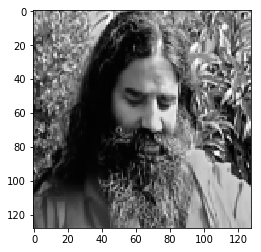

biswa confused with dhinchak_pooja


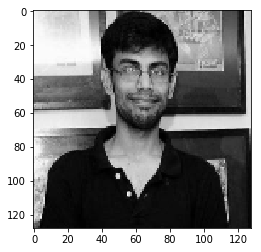

priya_prakash confused with dhinchak_pooja


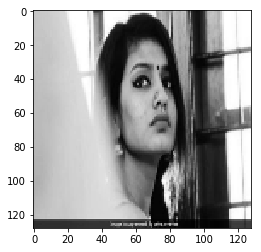

In [40]:
for w in wrong_predictions[::10]:
    print (classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()